In [2]:
import numpy as np
import pandas as pd
import nltk
import multiprocessing
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
nltk.download('wordnet')
nltk.download('stopwords')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
from nltk.corpus import stopwords
import twint
import nest_asyncio
import matplotlib.pyplot as plt
nest_asyncio.apply()

ModuleNotFoundError: No module named 'gensim'

In [38]:
c = twint.Config()
c.Search= 'bitcoin'

c.Min_likes = 10
c.Count = True
c.Until = "2022-04-02"
c.Since = "2021-03-25" #First few days of this month
c.Store_csv = True # This is for storing file in csv format (if you want in json file it will be c.Store_json=True)
c.Output = 'test.csv'

_ = twint.run.Search(c)

1509681695288614913 2022-03-31 18:58:59 -0500 <DWhitmanBTC> There’s only one thing we can do  Fix the money #Bitcoin
1509680938481029122 2022-03-31 18:55:58 -0500 <ynnos1999_> @CryptoWizardd @CryptoHayes when they start saying 1m bitcoin and 5 digit eth its  time to sell for the pullback, literally happens every single time
1509680633345417220 2022-03-31 18:54:46 -0500 <CaitlinLong_> THIS IS ONE OF A FEW potential big fights over U.S. #crypto regulation that seem likely to end up in court soon. A number of #bitcoin whales are gearing up for exactly these fights.
1509680596095701006 2022-03-31 18:54:37 -0500 <itscachemoney> Whenever I get too happy my brain automatically thinks about the time I mined a few bitcoin and sent them to the wrong address
1509680465506144258 2022-03-31 18:54:06 -0500 <Kripto_Poyraz> Aylık kapanış 45500 üzerinde olursa güzel olur.  #bitcoin
1509680338863366149 2022-03-31 18:53:35 -0500 <cberktavsan> Bitcoin düşüyor Ethereum düşmüyor ne kadar güzel market  when 

### Import it into dataframe

In [3]:
df = pd.read_csv('bitcoin.csv')

df = df[df["language"]=="en"] #Get rid of non-english tweets
# dropping all the duplicates tweets and keeping only the first values
df = df.drop_duplicates(subset="tweet",keep="first")
df = df[['date', 'tweet']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24699 entries, 0 to 60163
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    24699 non-null  object
 1   tweet   24699 non-null  object
dtypes: object(2)
memory usage: 578.9+ KB


c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Data processing down to lemma form

In [3]:
def lemmatize_text(text):
    return list([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

In [105]:
df['tweet'] = df['tweet'].astype(str)
df['tweet'] = df['tweet'].str.lower()  # Make everything lowercase
df['tweet'] = df['tweet'].str.replace(r'[^a-z\s]', '', regex=True)  # Remove anything not numeric

df['lemmatized'] = df.tweet.apply(lemmatize_text)  # Lemmatize each word
df['prepped'] = pd.DataFrame(df.lemmatized.tolist()).fillna('').astype(str).agg(' '.join, 1)  # Concatenate the lemmatized words
df = df[df['prepped'].notna()]
df = df[df["prepped"].str.contains("bitcoin")]  # Get rid of rows where the word bitcoin isnt present in the tweet

stop = stopwords.words('english')
pat = r'\b(?:{})\b'.format('|'.join(stop))  # Create regex pattern from stopwords
df['prepped'] = df['prepped'].str.replace(pat, '', regex=True)  # Remove stop words
df['prepped'] = df['prepped'].str.replace(r'\s+', ' ', regex=True)  # Remove spaces more than one space

df['no_stop'] = df.prepped.apply(lemmatize_text)  # Lemmatize each word

df.head()

,date,tweet,lemmatized,prepped,no_stop
2913,2022-05-02,this is how hex made the crypto market appear ...,"[this, is, how, hex, made, the, crypto, market...",alpha thrust bullish daily reversal best combo...,"[alpha, thrust, bullish, daily, reversal, best..."
2914,2022-05-02,new improved entityadjusted supply distributio...,"[new, improved, entityadjusted, supply, distri...",austin bitcoiners need help join u thursday au...,"[austin, bitcoiners, need, help, join, u, thur..."
2915,2022-05-02,bitboycrypto i first learned about bitcoin at ...,"[bitboycrypto, i, first, learned, about, bitco...",mikealfred cardano swipe wa really weak dont e...,"[mikealfred, cardano, swipe, wa, really, weak,..."
2916,2022-05-02,vechain vet yesterday vechainthor accounts ...,"[vechain, vet, yesterday, vechainthor, account...",coachpbtc intocryptoverse bitcoin orange chip ...,"[coachpbtc, intocryptoverse, bitcoin, orange, ..."
2917,2022-05-02,satoshisarah nobody owns it thats why theres c...,"[satoshisarah, nobody, owns, it, thats, why, t...",bitcoin go,"[bitcoin, go]"


### Save part of dataframe as test

In [106]:
test = df[0:2000]
df = df[2000:]
test.to_csv('test.csv', index=False)

In [35]:
w2v = Word2Vec(min_count=4,
                window=5,
                vector_size=300,
                sample=1e-5,
                alpha=0.03,
                min_alpha=0.0007,
                negative=20,
                seed=42,
                workers=multiprocessing.cpu_count()-2)

w2v.build_vocab(df.no_stop, progress_per=500)

In [42]:
w2v.train(df.no_stop, total_examples=len(df), epochs=80, report_delay=1)
w2v.wv.most_similar(positive=['sell'])

[('alert', 0.9555611610412598),
 ('came', 0.9448983073234558),
 ('basic', 0.9428791403770447),
 ('mini', 0.9405869841575623),
 ('character', 0.9374615550041199),
 ('r', 0.9367951154708862),
 ('alpha', 0.9362068772315979),
 ('edition', 0.9358429908752441),
 ('everyones', 0.9350059628486633),
 ('choosing', 0.9323453307151794)]

In [90]:
word_vector = w2v.wv
model = KMeans(n_clusters=5, max_iter=1000, random_state=42, n_init=50).fit(X=word_vector.vectors.astype('double'))

In [95]:
word_vector.similar_by_vector(model.cluster_centers_[4], topn=100, restrict_vocab=None)

[('task', 0.9774011969566345),
 ('great', 0.973717451095581),
 ('birthday', 0.9735874533653259),
 ('audit', 0.973149299621582),
 ('millionaire', 0.9725526571273804),
 ('ring', 0.9718733429908752),
 ('updated', 0.971197783946991),
 ('casino', 0.9710255265235901),
 ('checkout', 0.9709904789924622),
 ('juicy', 0.9707861542701721),
 ('tip', 0.9698817133903503),
 ('passive', 0.9698745608329773),
 ('usdc', 0.9689943790435791),
 ('harmonyone', 0.9689796566963196),
 ('left', 0.9685894846916199),
 ('grow', 0.9683548808097839),
 ('dex', 0.9675458073616028),
 ('nexo', 0.9674485921859741),
 ('testing', 0.967409074306488),
 ('saitamawolfpack', 0.967171311378479),
 ('deposit', 0.9668306708335876),
 ('farm', 0.9667794704437256),
 ('register', 0.9664585590362549),
 ('tweeting', 0.9644635319709778),
 ('finished', 0.9640051126480103),
 ('grab', 0.9631189107894897),
 ('apr', 0.9626862406730652),
 ('gate', 0.9622088074684143),
 ('stream', 0.9619221687316895),
 ('drink', 0.961713969707489),
 ('fly', 0.9612

In [97]:
# Creating a DataFrame of words with their embeddings and cluster values
words = pd.DataFrame(word_vector.index_to_key)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vector[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])

In [98]:
words['cluster_value'] = [-1 if i==0 else 1 if i==4 else 0 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
words[words["cluster_value"]==-1].sort_values("closeness_score")

,words,vectors,cluster,cluster_value,closeness_score
1405,died,"[0.5526212, 0.40486404, -0.062453747, -0.36026...",0,-1,0.169907
807,ltc,"[0.35099414, 0.2007427, 0.009689828, -0.246076...",0,-1,0.322882
144,xrp,"[0.4266231, 0.20883259, 0.08483954, -0.2820574...",0,-1,0.337508
3175,eos,"[0.30459625, 0.17886387, -0.0523775, -0.225188...",0,-1,0.342765
1914,bar,"[-0.035773285, -0.18076387, -0.3484708, 0.2587...",0,-1,0.379302
...,...,...,...,...,...
1112,downside,"[0.14661273, -0.15494701, -0.31981233, 0.01528...",0,-1,3.039766
2169,kk,"[0.08923957, -0.155825, -0.29709536, 0.0258528...",0,-1,3.046409
843,capitulation,"[0.1646177, -0.15468073, -0.31849667, -0.01160...",0,-1,3.103488
2993,rejection,"[0.087001175, -0.15687859, -0.2892456, 0.01403...",0,-1,3.381994


In [100]:
positive = ['buy','bull','moon','shib','profit','rich']
neutral = ['analysis','sentiment','trade']
negative= ['sell','bear','fear','dump','poor']
for i in positive:
    words.loc[words["words"]==i,"cluster_value"]=1
    
for i in neutral:
    words.loc[words["words"]==i,"cluster_value"]=0
    
for i in negative:
    words.loc[words["words"]==i,"cluster_value"]=-1

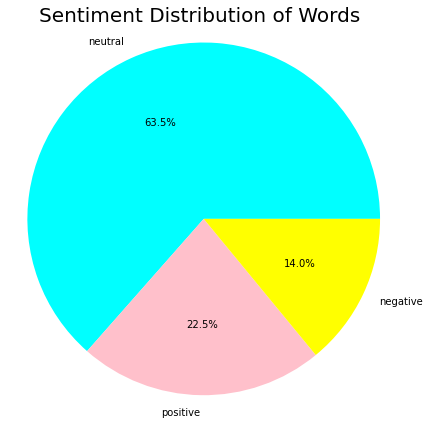

,index,sentiments
0,neutral,2171
1,positive,768
2,negative,480


In [102]:
# Plotting pie chart of Sentiment Distribution of words
emotion = {0: "neutral",
           1: "positive",
          -1: "negative"}

words["sentiments"] = words["cluster_value"].map(emotion)

fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["cyan","pink","yellow"]
df_pie=words["sentiments"].value_counts().reset_index()
plt.pie(df_pie["sentiments"],labels=df_pie["index"],radius=2,colors=colors,autopct="%1.1f%%")
plt.axis('equal')
plt.title("Sentiment Distribution of Words ", fontsize=20)
plt.show()
df_pie

In [103]:
words_dict = dict(zip(words.words, words.cluster_value))

In [104]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(words_dict, f)